In [1]:
# Make all the imports in this cell.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# Fetch the data from provided files.
data = pd.read_csv("/kaggle/input/tabular-playground-series-jun-2022/data.csv")
submission = pd.read_csv("/kaggle/input/tabular-playground-series-jun-2022/sample_submission.csv", index_col="row-col")
print(data.isnull().sum())

row_id        0
F_1_0     18397
F_1_1     18216
F_1_2     18008
F_1_3     18250
          ...  
F_4_10    18225
F_4_11    18119
F_4_12    18306
F_4_13    17995
F_4_14    18267
Length: 81, dtype: int64


Create a function that evaluates the imputated dataset.

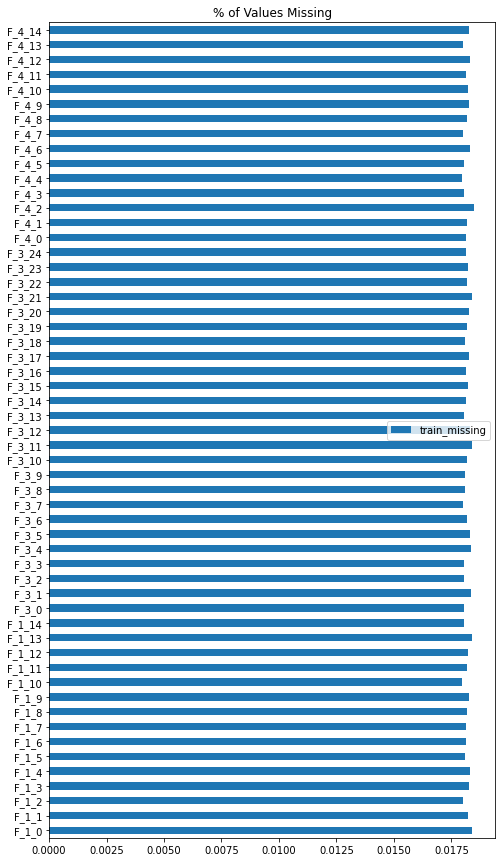

In [3]:
# This returns every column that has missing values + how many % of the column's rows is missing.
def show_perc_values_missing(df):
    ncounts = pd.DataFrame([df.isna().mean()]).T
    ncounts = ncounts.rename(columns={0: "train_missing"})
    ncounts.query("train_missing > 0").plot(
        kind="barh", figsize=(8, 15), title="% of Values Missing"
    )
    plt.show()
    return [i for i in ncounts.query("train_missing > 0").index]
missingval_cols = show_perc_values_missing(data)


Generate a dataset where are no missing values + randomly take 18% of values rid (d.h. fake dataset with missing values).

In [4]:
# Generate a feature to track the number of missing values in a row.
data["n_missing"] = data[missingval_cols].isna().sum(axis=1)
# Dataset with only rows where are no missing values.
rows_with_no_missing = data.query("n_missing == 0")
rows_with_no_missing.drop(['row_id', 'n_missing'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


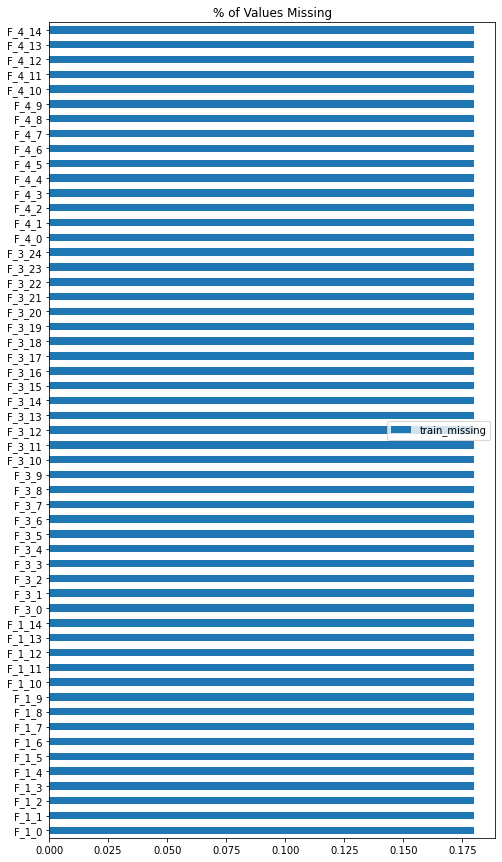

In [5]:
# Create a copy of the df that doesn't have missing values.
fake_missing = rows_with_no_missing.copy()
# For every column in columns that have missing values, let there be as much (18%) missing values in the corresponding columns in rows_with_no_missing.
for col in missingval_cols:
    vals_to_nan = rows_with_no_missing[col].sample(frac=0.18).index
    fake_missing.loc[vals_to_nan, col] = np.NaN
# Plot to verify that this operation was successfull.
res = show_perc_values_missing(fake_missing)

Create datasets for training (train + validate). Make sure that they're created correctly.

In [6]:
X_train, X_valid = train_test_split(fake_missing, test_size=0.3, random_state=42)
Y_train = rows_with_no_missing.loc[X_train.index]
Y_valid = rows_with_no_missing.loc[X_valid.index]
X_all = fake_missing
Y_all = rows_with_no_missing
train_correct = X_train.shape == Y_train.shape
valid_correct = X_valid.shape == Y_valid.shape
train_correct, valid_correct

(True, True)

Make the imputations with the train dataset and make sure that there are no non-imputated values left. Do this with both the train dataset and validation data set.

In [7]:
impmean = SimpleImputer(missing_values=np.nan, strategy="mean")
impmode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
# Train set.
train_imputed = X_train.copy()
train_imputed[:] = impmean.fit_transform(X_train)
score1 = mean_squared_error(Y_train, train_imputed)
# Validation set.
validation_imputed = X_valid.copy()
validation_imputed[:] = impmean.fit_transform(X_valid)
score2 = mean_squared_error(Y_valid, validation_imputed)
print("Are all values imputed? " + str(train_imputed.isnull().sum().iloc[0] == 0) + " " + str(validation_imputed.isnull().sum().iloc[0] == 0))
print("Score (MSA) of train set: ", str(score1), ", and validation set: " + str(score2))

Are all values imputed? True True
Score (MSA) of train set:  0.248809425811488 , and validation set: 0.249129075266735


Now after that testing round, let's make a function that does the validation and returns the errors with given error meter.

In [8]:
# Returns a tuple, where tuple[0]=trainset_error and tuple[1]=validationset_error
def test_imputation(strat, error_calc_function):
    imptr = SimpleImputer(missing_values=np.nan, strategy=strat)
    train_imp = X_train.copy()
    train_imp[:] = imptr.fit_transform(X_train)
    score1 = error_calc_function(Y_train, train_imp)
    
    validation_imp = X_valid.copy()
    validation_imp[:] = imptr.fit_transform(X_valid)
    score2 = error_calc_function(Y_valid, validation_imp)
    return (score1, score2)

In [9]:
# Using the function.
mf = test_imputation("most_frequent", mean_squared_error)
mean = test_imputation("mean", mean_squared_error)
median = test_imputation("median", mean_squared_error)
print(mf, mean, median)

(0.371396890147471, 0.6276723257773794) (0.248809425811488, 0.249129075266735) (0.24927801247836764, 0.2496402969067418)


It seems to be that when we use the SimpleImputator , the best way to imputate is to replace missing values with mean. Let's look at other ways for replacing, with ready-made imputation modules.

In [10]:
# Iterative imputation. Using GPU here.

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost

imputer_it = IterativeImputer(estimator=xgboost.XGBRegressor(n_estimators=500, tree_method='gpu_hist', predictor="gpu_predictor"), verbose=2, max_iter=20)
data[:] = imputer_it.fit_transform(data)

[IterativeImputer] Completing matrix with shape (1000000, 82)
[IterativeImputer] Ending imputation round 1/20, elapsed time 816.08
[IterativeImputer] Change: 26.32821202993295, scaled tolerance: 999.999 
[IterativeImputer] Early stopping criterion reached.


In [11]:
# k-NN imputation. Skipping this.

# from sklearn.impute import KNNImputer
# knnimputer = KNNImputer(n_neighbors=4)
# data = knnimputer.fit_transform(official_data)

The previous ones take a lot of time. Let's look if we have other solutions, for example.

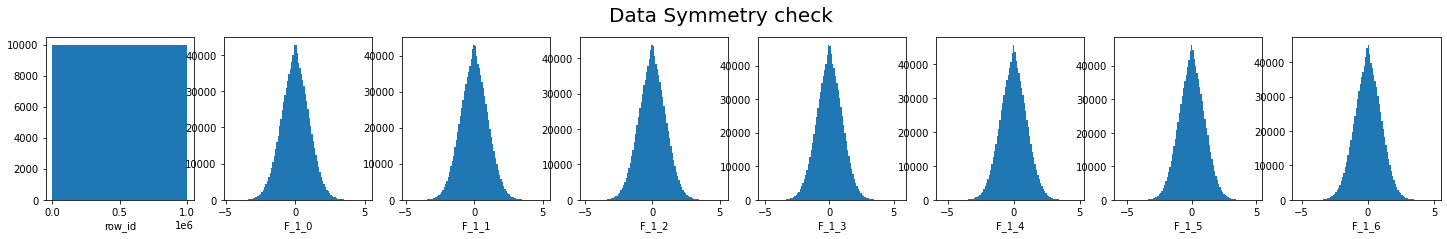

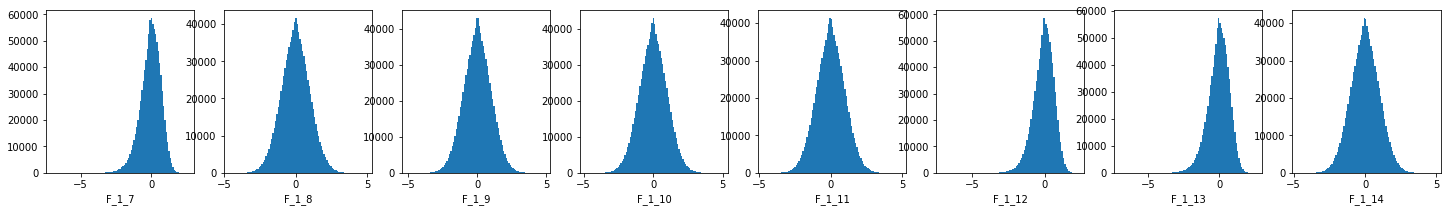

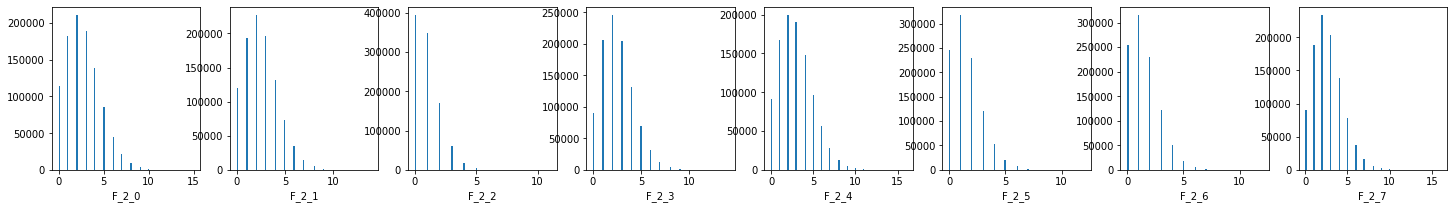

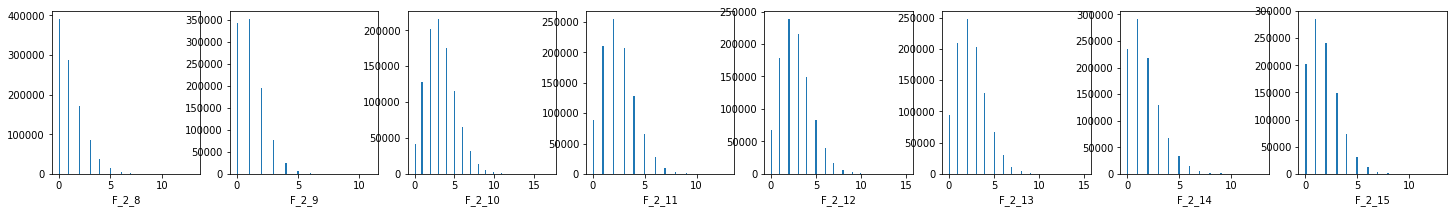

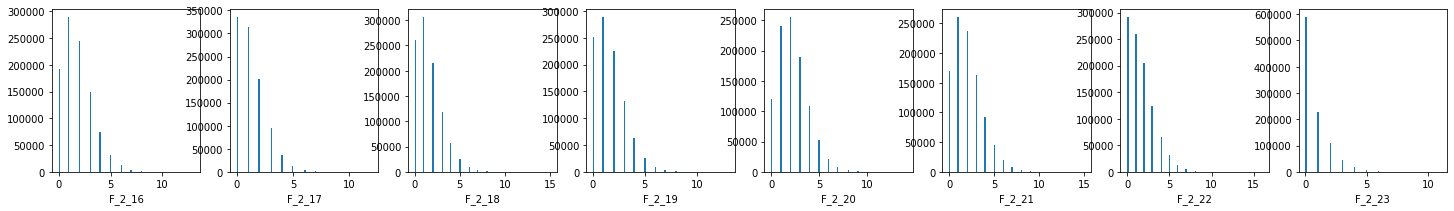

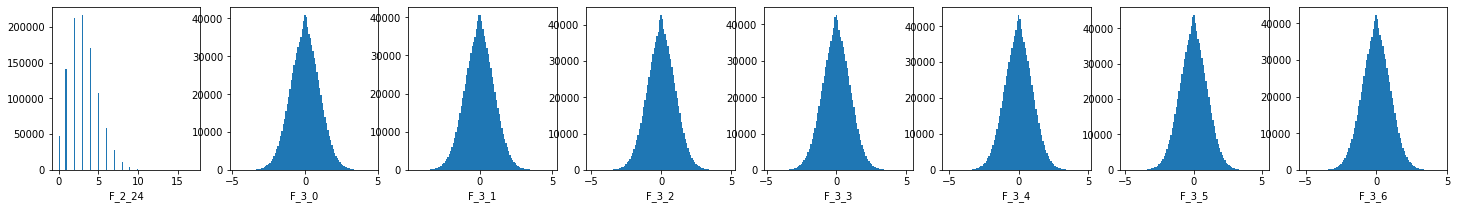

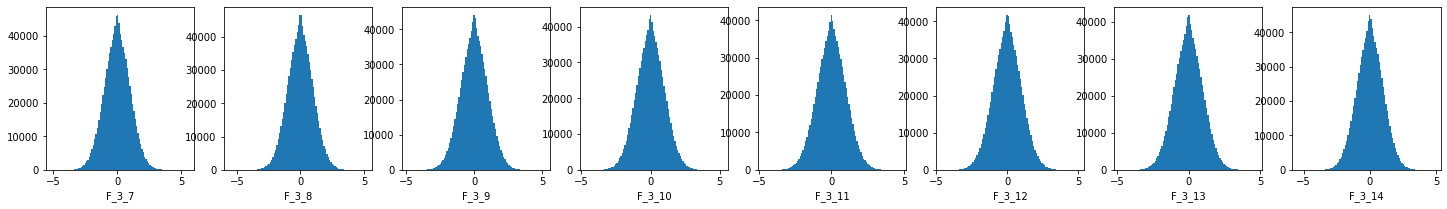

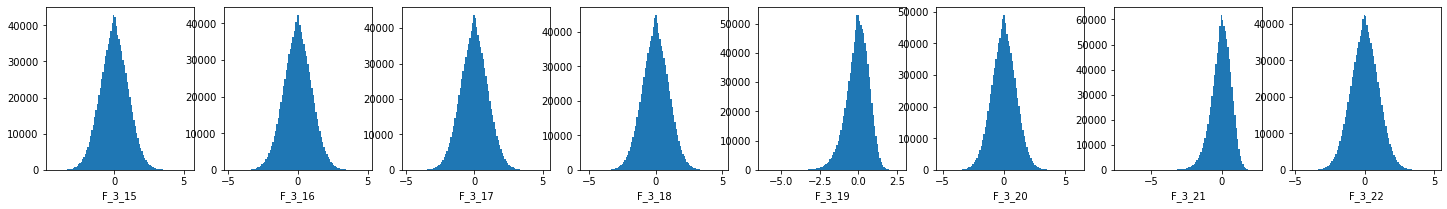

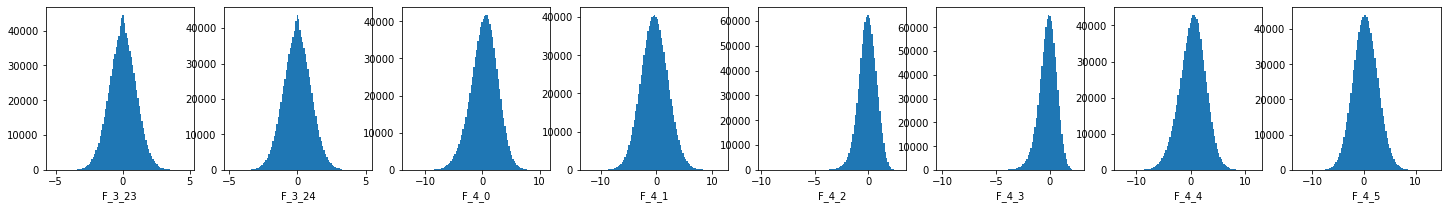

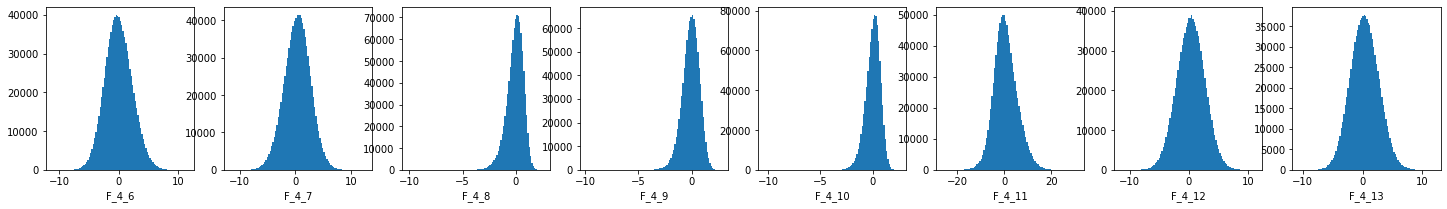

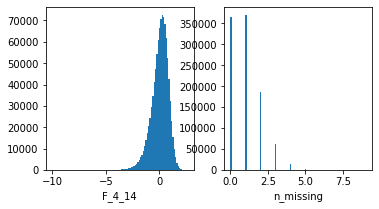

In [12]:
# Let's check how every column behaves symmetrically. The mean value as an imputation value might be the best for some, but not for all, possibly.
features = data.columns
ncols = 8
for i, f in enumerate(features):
    if i % ncols == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(25, 3))
        if i == 0: plt.suptitle('Data Symmetry check', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    plt.hist(data[f], bins=100) #, bins=200
    plt.xlabel(f)
plt.show()

Here we can see, that every column has either normally distributed, left skewed or right skewed data. Based on this, we can calculate calculate the imputations manually with the following info:
- For normally distributed data, all *mean*, *mode*, *median* are equally good.
- For left skewed data (values are concentrated on the right side), *mode* is the best.  
- For right skewed data (values are concentrated on the left side), *mode* is the best as well.
This didn't lead to anything but it looks fancy though.

Turn the imputed values into a suitable form, format the values to be submitted and create the submission file.

In [13]:
data = data.drop(["n_missing", "row_id"], axis=1)
for i in tqdm(submission.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    submission.loc[i, 'value'] = data.loc[row, col]

submission.to_csv('submission.csv')

100%|██████████| 1000000/1000000 [01:29<00:00, 11137.07it/s]
